In [7]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

In [8]:
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'sample_edf.edf', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'suj9_d2final.edf', 'suj9_d2final_annotations.txt', 'Training Data Frame', 'zsample_edf.edf']


In [9]:
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()

In [10]:
file_to_read, fileName = eegPinelineDesign.pick_sample_file(EDFfiles,n=0)
print(fileName)

s5d2_final


In [11]:
raw = mne.io.read_raw_edf(file_to_read,stim_channel=None, preload=True)

Extracting edf Parameters from s5d2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  3383.999 secs...
[done]
Ready.


In [5]:
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,low_frequency=5,high_frequency=50)
raw.pick_channels(['F3','F4','C3','C4','O1','O2'])

Extracting edf Parameters from s5d2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  3383.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    5, 6, 0, 0, 7
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 4 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
Band-pass filtering from 5 - 50 Hz


<RawEDF  |  n_channels x n_times : 6 x 3384000>

In [6]:
labelFind = eegPinelineDesign.re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = eegPinelineDesign.pd.read_csv(annotation_to_read[0])

In [7]:
spindles=[]
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])

# Demostration of how the centralize algorithm works

[139]


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


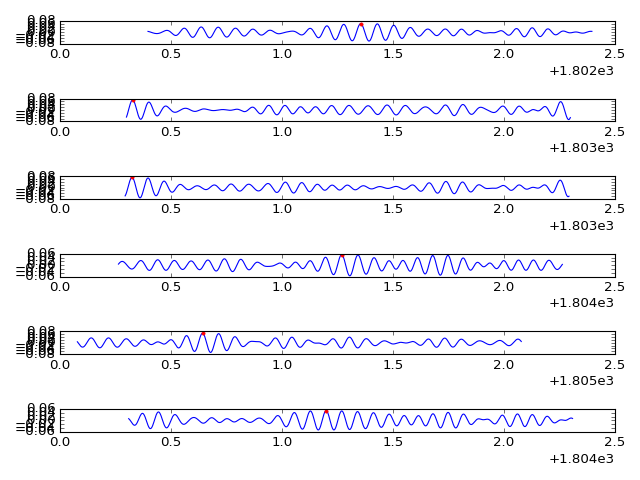

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 16.5Hz is only 8.9dB.
  '%0.1fdB.' % (att_freq, att_db))


In [8]:
windowsize=2;sample=np.random.choice(len(spindles),1);print(sample)
startPoint = spindles[sample]-windowsize;endPoint = spindles[sample]+windowsize
start,stop = raw.time_as_index([startPoint,endPoint])

plt.figure(0)
for ii in range(6):
    plt.subplot(6,1,ii+1)
    tempsegment,timespan = raw[ii,start:stop]
    centerxval = timespan[np.argmax(abs(tempsegment[0,:]))]
    startPoint=centerxval-windowsize/2;endPoint=centerxval+windowsize/2
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempsegment,time=raw[ii,start:stop]
    segment = mne.filter.band_pass_filter(tempsegment[0,:],1000,11.5,16);
    segment = (segment - np.mean(segment))/(np.linalg.norm((segment - np.mean(segment))))
    peakids = list(abs(segment)).index(max(segment))
    plt.plot(time,segment)
    plt.plot(time[peakids],segment[peakids],'r.')
    plt.tight_layout()

<IPython.core.display.Javascript object>


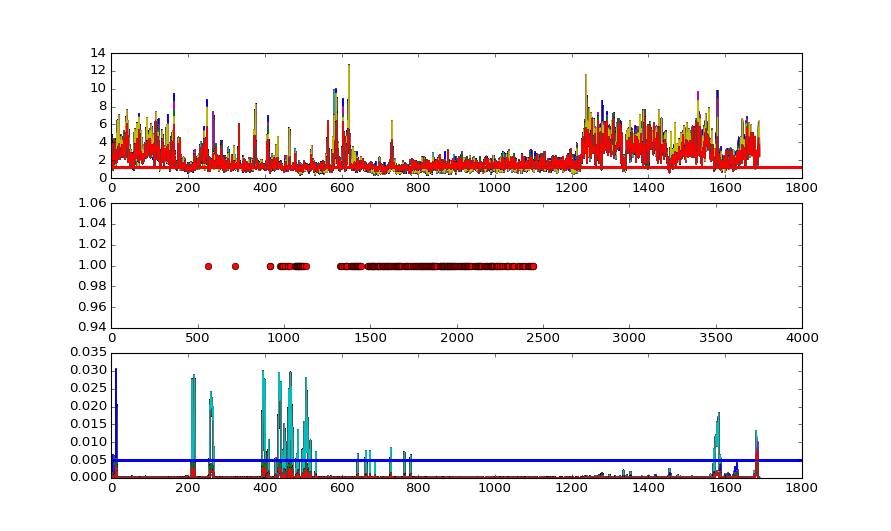

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 7.5Hz is only 9.0dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 16.5Hz is only 8.9dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 29.5Hz is only 9.1dB.
  '%0.1fdB.' % (att_freq, att_db))


(0, 4000)

In [9]:
plt.figure(2)
for ii in range(6):
    windowsize=2;index1=[];index2=[]
    endPoint = 2;startPoint=endPoint-windowsize
    distance_to_end = raw.last_samp/1000 - endPoint
    while distance_to_end >0:
        start,stop = raw.time_as_index([startPoint,endPoint])
        segment, time = raw[ii,start:stop];
        filter_alpha = mne.filter.band_pass_filter(segment,1000,8,12);
        RMS_alpha = np.sqrt(sum(filter_alpha[0]**2)/len(filter_alpha))
        filter_spindle = mne.filter.band_pass_filter(segment,1000,11.5,16)
        RMS_spindle = np.sqrt(sum(filter_spindle[0]**2))/len(filter_spindle)
        filter_muscle = mne.filter.band_pass_filter(segment,1000,30,40)
        RMS_muscle = np.sqrt(sum(filter_muscle[0]**2)/len(filter_muscle))
        #print(RMS_alpha,RMS_spindle,RMS_muscle)
        index1.append(RMS_alpha/RMS_spindle)
        index2.append(RMS_muscle)
        endPoint += windowsize/1#determine step size
        startPoint=endPoint-windowsize
        distance_to_end = raw.last_samp/1000 - endPoint
        
        plt.subplot(311)
        plt.plot(index1)
        plt.axhline(1.2,color='r')
        plt.subplot(313)
        plt.plot(index2)
        plt.axhline(5*10e-4)
plt.subplot(312)
plt.plot(np.array(spindles),np.ones(np.array(spindles).shape),'ro')
plt.xlim([0,4000])

# how many spindles in this example?

In [10]:
len(spindles)

281

# Grade spindle samples across 6 channels.
<br /> For me, grading only for one channel does not seems to be a good example for training, because overall, the spindle markers are for 6 channels. Therefore, I have:
$$ \text{if} \frac{RMS_\alpha}{RMS_{spindle}} < 1.2 \rightarrow \text{add 1 point to the grading}$$
$$ \text{if } RMS_{muscle} > 5e^{-4} \rightarrow \text{subtract 1 point from the grading}$$
$$ \text{if score = 1, spindle example for one channel score 1}$$
$$ \text{if score = 0, spindle exampmle for one channel score} \frac{1}{6}$$
$$ \text{if score = -1, spindle example for one channle score 0}$$

In [11]:
def normalized(x):
    #print(x.shape)
    normalized_x = (x-np.mean(x))/np.dot((x-np.mean(x)),(x-np.mean(x)))
    return normalized_x
windowsize=2;startSize=0.1;sample_ind={}
for idx,names in enumerate(['F3','F4','C3','C4','O1','O2']):
    sample_ind[names]=[]
    for sample in range(len(spindles)):

        startPiont = spindles[sample]-startSize*windowsize;endPoint = spindles[sample]+(1-startSize)*windowsize
        start,stop=raw.time_as_index([startPiont,endPoint])
        tempsegment,timespan = raw[idx,start:stop]
        centerxval = timespan[np.argmax(abs(tempsegment[0,:]))]
        startPoint=centerxval-windowsize/2;endPoint=centerxval+windowsize/2
        start,stop=raw.time_as_index([startPoint,endPoint])
        segment,time=raw[idx,start:stop]
        filter_alpha = mne.filter.band_pass_filter(segment,1000,8,12);
        RMS_alpha = np.sqrt(sum(filter_alpha[0]**2)/len(filter_alpha))
        filter_spindle = mne.filter.band_pass_filter(segment,1000,11.5,16)
        RMS_spindle = np.sqrt(sum(filter_spindle[0]**2))/len(filter_spindle)
        filter_muscle = mne.filter.band_pass_filter(segment,1000,30,40)
        RMS_muscle = np.sqrt(sum(filter_muscle[0]**2)/len(filter_muscle))
        point = 0
        if RMS_alpha/RMS_spindle < 1.2:
            point +=1
        if RMS_muscle >5*10e-4:
            point -=1
        if point ==1:
            sample_ind[names].append(1)
        elif point ==0:
            sample_ind[names].append(1/6)
        else:
            sample_ind[names].append(0)

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 7.5Hz is only 9.0dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 16.5Hz is only 8.9dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 29.5Hz is only 9.1dB.
  '%0.1fdB.' % (att_freq, att_db))


In [12]:
tempe = pd.DataFrame(sample_ind)
pd.set_option('display.max_rows', len(tempe))
print(tempe)

           C3        C4        F3        F4        O1        O2
0    0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
1    1.000000  1.000000  0.166667  0.166667  0.166667  0.166667
2    1.000000  0.166667  0.166667  1.000000  1.000000  0.166667
3    0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
4    0.166667  1.000000  1.000000  0.166667  1.000000  1.000000
5    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
6    1.000000  0.166667  1.000000  1.000000  1.000000  0.166667
7    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
8    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
9    1.000000  1.000000  0.166667  1.000000  1.000000  1.000000
10   0.166667  0.166667  0.000000  0.166667  0.166667  0.166667
11   1.000000  1.000000  0.166667  1.000000  1.000000  1.000000
12   1.000000  1.000000  0.166667  1.000000  1.000000  1.000000
13   1.000000  1.000000  0.166667  1.000000  1.000000  1.000000
14   1.000000  0.166667  1.000000  1.000

In [13]:
tempe['sum']=tempe.sum(axis=1)

<IPython.core.display.Javascript object>


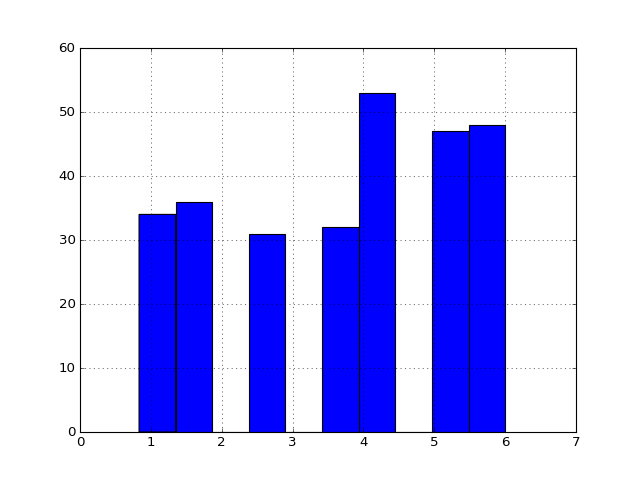

0      1.000000
1      2.666667
2      3.500000
3      1.000000
4      4.333333
5      6.000000
6      4.333333
7      6.000000
8      6.000000
9      5.166667
10     0.833333
11     5.166667
12     5.166667
13     5.166667
14     4.333333
15     2.500000
16     2.500000
17     6.000000
18     4.333333
19     5.166667
20     1.833333
21     1.833333
22     6.000000
23     5.166667
24     5.166667
25     5.166667
26     5.166667
27     5.166667
28     3.500000
29     3.500000
30     2.666667
31     6.000000
32     1.833333
33     6.000000
34     0.833333
35     2.500000
36     5.166667
37     4.333333
38     5.166667
39     4.333333
40     6.000000
41     5.166667
42     5.166667
43     6.000000
44     6.000000
45     6.000000
46     6.000000
47     6.000000
48     6.000000
49     3.500000
50     5.166667
51     5.166667
52     6.000000
53     5.166667
54     6.000000
55     6.000000
56     6.000000
57     4.333333
58     6.000000
59     2.666667
60     5.166667
61     6.000000
62     6

In [14]:
plt.figure(9)
print(tempe['sum'])
tempe['sum'].hist(bins=10)

<IPython.core.display.Javascript object>


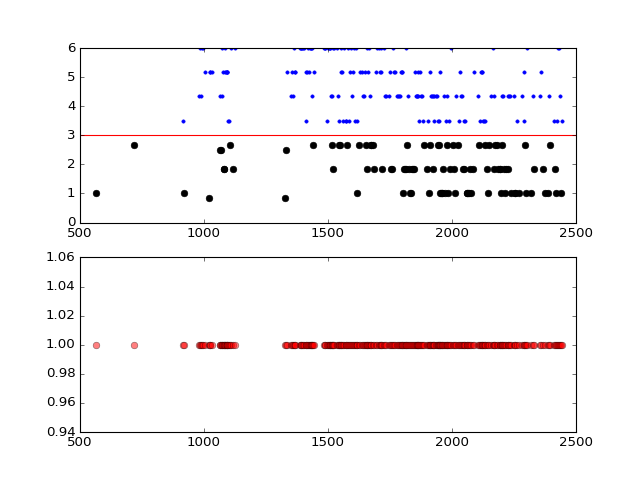

(500, 2500)

In [15]:
plt.figure(4)
plt.subplot(211)
plt.plot(np.array(spindles),tempe['sum'],'b.')
plt.axhline(3,color='r')
for ii in range(len(tempe)):
    if tempe['sum'][ii] < 3:
        plt.plot(spindles[ii],tempe['sum'][ii],'ko')
plt.subplot(212)
plt.plot(np.array(spindles),np.ones(np.array(spindles).shape),'ro',alpha=0.5)
plt.xlim([500,2500])

In [12]:
raw.save('sample_edf.edf',overwrite=True)

Overwriting existing file.
Writing C:\Users\ning\Downloads\training set\sample_edf.edf
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
Writing ...
W

C:\Anaconda3\lib\site-packages\mne\utils.py:268: UserWarning: This filename (sample_edf.edf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  '%s' % (fname, filetype, print_endings))
